# Anomaly detection techniques

In [65]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

In [66]:
%run anomaly_detection_common.ipynb

## Loading dataset

In [67]:
dataset = ATSFDataset().load()
data_df = dataset.get_df()
data_df.head(100)

,timestamp,value_f,value_c,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,69.880835,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,71.220227,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,70.877805,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,68.959400,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,69.283551,20.713084,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...,...
95,2013-07-07 23:00:00,64.246634,17.914796,23,0,6,0,13732380,0
96,2013-07-08 00:00:00,62.480785,16.933769,0,0,0,1,13732416,2
97,2013-07-08 01:00:00,62.030554,16.683641,1,0,0,1,13732452,2
98,2013-07-08 02:00:00,63.411560,17.450867,2,0,0,1,13732488,2


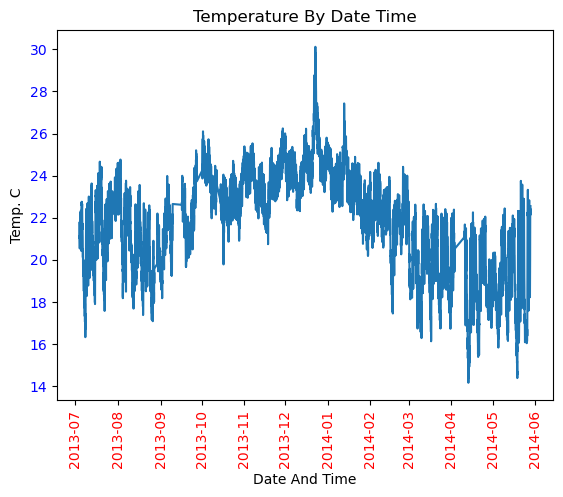

In [68]:
dataset.plot()

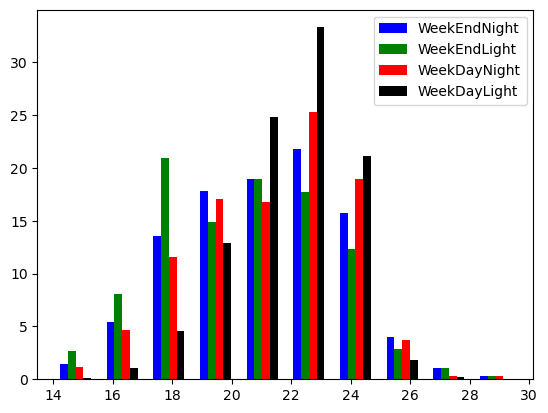

In [69]:
dataset.plot_categories()